In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy.stats import spearmanr
%matplotlib inline


In [2]:
from utils import data
from utils.paper import mann_whitney_hyper_label_printer, spearmanr_hyper_label_printer
from cohorts.functions import missense_snv_count
cohort = data.init_cohort(normalized_per_mb=False, exclude_patient_ids=set(), only_patients_with_bams=True)
col, cohort_df = cohort.as_dataframe(missense_snv_count, join_with=['pdl1'], return_cols=True)
cohort_df['Benefit'] = cohort_df['is_benefit']
cohort_df['Response'] = cohort_df['benefit'].map(lambda v: cohort.benefit_plot_name if v 
                                                 else 'No ' + cohort.benefit_plot_name)

annotated_effects = cohort.load_polyphen_annotations(as_dataframe=True)

{'dataframe_hash': 6797089423601767780,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}
inner join with pdl1: 26 to 26 rows


In [3]:
from pyensembl import ensembl75

In [4]:
from utils.data import patient_id_to_str
kallisto_data = pd.read_csv('../bladder-kallisto-tximport.csv', index_col=0)
kallisto_data['gene_name'] = kallisto_data.index.map(lambda gid: ensembl75.gene_name_of_gene_id(gid))
kallisto_data = kallisto_data.reset_index().drop(['index'], axis=1).set_index('gene_name').T.reset_index()
kallisto_data['patient_id'] = kallisto_data['index'].map(patient_id_to_str)
kallisto_data.head()

gene_name,index,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,RPS9,PCDHB19P,PRPF31,MBOAT7,LDHAL6FP,AC005795.1,PRKCD,OR6R2P,TSEN34,patient_id
0,40,540.2140,56.00000,649.00029,830.8775,582.19160,786.00010,454.547440,4631.10524,748.34841,...,2019.060,609.9150,289.089618,558.051916,5.5000,3.55145,2297.733000,1.00419,121.806427,0040
1,471,1133.3780,77.00000,445.99969,903.3402,456.25392,342.99990,984.792258,1619.13800,989.51800,...,3040.690,107.7640,195.470580,505.955050,6.0000,6.58465,1150.999900,1.00000,315.858201,0471
2,522,1182.8780,19.00004,1216.99897,2934.5000,1905.22708,2080.99702,3423.509560,2694.14115,5283.14540,...,2943.530,21.2127,195.200002,294.738990,17.5000,6.08811,2669.242960,1.01251,4.892077,0522
3,1233,201.0806,24.00000,225.99970,616.9180,776.95600,945.99969,1183.850300,710.33517,1073.24268,...,2863.210,175.2840,123.326675,267.840510,15.7641,0.00000,774.582010,2.12905,194.579000,1233
4,1249,312.2663,163.00000,102.99996,204.7884,498.61147,107.99996,733.000220,511.54965,356.15960,...,547.199,2.5000,54.899960,22.543993,9.0000,14.53360,50.999949,0.00000,6.626220,1249


In [5]:
expr_data = pd.melt(kallisto_data.drop('index', axis=1), id_vars='patient_id', value_name='scaledTPM')
cohort_expr_data = cohort_df.merge(
    pd.melt(kallisto_data.drop('index', axis=1), id_vars='patient_id', value_name='scaledTPM'))
cohort_expr_data['Gene'] = cohort_expr_data['gene_name']
expr_data.head()

,patient_id,gene_name,scaledTPM
0,0040,TSPAN6,540.2140
1,0471,TSPAN6,1133.3780
2,0522,TSPAN6,1182.8780
3,1233,TSPAN6,201.0806
4,1249,TSPAN6,312.2663


In [6]:
# Print mutated
# Plot Fisher's Exact for mutated vs not, benefit vs not
# Mann - Whitney 
# AUC with gene expression

from cohorts.plot import mann_whitney_plot, fishers_exact_plot, roc_curve_plot

def create_gene_summary(gene_name):
    mutations = annotated_effects[annotated_effects.gene == gene_name]
    expression = kallisto_data[['patient_id', gene_name]]
    
    df = cohort_df.copy()
    
    mut_col = gene_name + ' Mutated'
    df[mut_col] = df.patient_id.isin(mutations.patient_id)
    
    expr_col = gene_name + ' scaledTPM'
    expression.rename(columns={gene_name : expr_col}, inplace=True)
    df = df.merge(expression, how='left')
    
    if len(mutations) > 0:
        cols = 3
        width = 10
        height = 5
    else:
        cols = 2
        width = 8
        height = 4
    f, ax = plt.subplots(1, cols, figsize=(width, height))
    
    if len(mutations) > 0:
        mut_plot = fishers_exact_plot(data=df, condition1='Response', condition1_value=cohort.benefit_plot_name,
                                      condition2=mut_col, ax=ax[0])
        fishers_exact_hyper_label_printer(mut_plot, gene_name + "_mut")
        mut_plot.plot.set_ylim(0, 1)
        plt.ylim(0, 1)
    
    expr_plot = mann_whitney_plot(data=df, 
                                  condition='Response', 
                                  distribution=expr_col, 
                                  condition_value=cohort.benefit_plot_name, 
                                  ax=ax[-2])
    mann_whitney_hyper_label_printer(expr_plot, gene_name)
    df['benefit'] = df['benefit'].astype(int)
    expr_roc = roc_curve_plot(data=df, value_column=expr_col, outcome_column='benefit', ax=ax[-1])
    f.tight_layout()
    return mutations[['patient_id', 'aa_change', 'hvar_pred', 'hvar_prob', 'hdiv_pred']]

/home/tavi/miniconda2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


Mann-Whitney test: U=98.0, p-value=0.257704686002 (two-sided)
{{{HAVCR2_plot}}}
{{{HAVCR2_benefit:339.74 (range 25.46-1663.50)}}}
{{{HAVCR2_no_benefit:131.51 (range 9.92-1142.89)}}}
{{{HAVCR2_mw:n=26, Mann-Whitney p=0.26}}}
HAVCR2 scaledTPM, Bootstrap (samples = 100) AUC:0.645937198978, std=0.13250024697


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


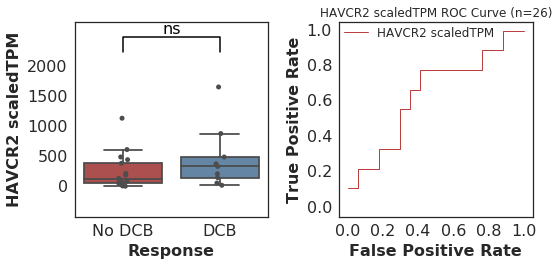

In [7]:
create_gene_summary('HAVCR2')

In [8]:
cohort_df.merge(
    kallisto_data[
        ['patient_id', 'HAVCR2']
    ])[
    ['patient_id', 'IC Level', col, 'Liver Mets', 'HAVCR2', 'os', 'deceased', 'pfs', 'progressed', 'benefit']
].sort_values('HAVCR2', ascending=False).head()

,patient_id,IC Level,missense_snv_count,Liver Mets,HAVCR2,os,deceased,pfs,progressed,benefit
7,2131,IC2,412,0,1663.49700,630,False,560,False,True
10,2849,IC1,304,0,1142.89290,586,True,75,True,False
9,2389,IC2,57,0,886.85240,651,False,646,False,True
2,0522,IC1,23,1,620.08135,76,True,58,True,False
6,1994,IC0,3,0,496.90472,403,True,121,True,False


Mann-Whitney test: U=93.0, p-value=0.388495557235 (two-sided)
{{{LAG3_plot}}}
{{{LAG3_benefit:202.00 (range 22.00-1652.00)}}}
{{{LAG3_no_benefit:135.00 (range 18.00-575.00)}}}
{{{LAG3_mw:n=26, Mann-Whitney p=0.39}}}
LAG3 scaledTPM, Bootstrap (samples = 100) AUC:0.616840224351, std=0.130472948334


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


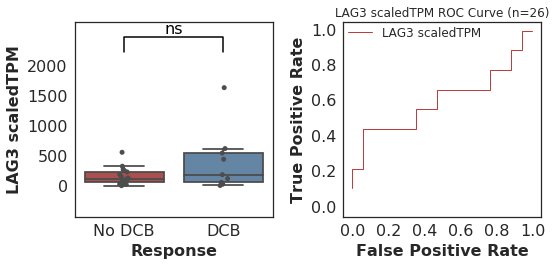

In [9]:
create_gene_summary('LAG3')

Mann-Whitney test: U=93.0, p-value=0.388495557235 (two-sided)
{{{CD274_plot}}}
{{{CD274_benefit:129.00 (range 31.00-976.00)}}}
{{{CD274_no_benefit:102.00 (range 6.00-1424.00)}}}
{{{CD274_mw:n=26, Mann-Whitney p=0.39}}}
CD274 scaledTPM, Bootstrap (samples = 100) AUC:0.603553470189, std=0.105511144829


,patient_id,aa_change,hvar_pred,hvar_prob,hdiv_pred


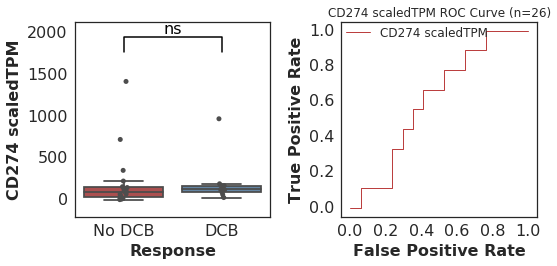

In [10]:
create_gene_summary('CD274')

{{{tumor_pdl1_vs_ic_level}}}


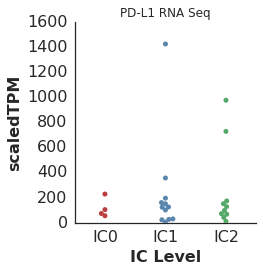

In [11]:
sb.factorplot(
    data = cohort_expr_data[cohort_expr_data.gene_name == 'CD274'],
    y = 'scaledTPM',
    x = 'IC Level',
    kind='swarm'
)
plt.title("PD-L1 RNA Seq")
plt.ylim(0, )
print("{{{tumor_pdl1_vs_ic_level}}}")

{{{tumor_pdl1_vs_ic_level_plot}}}
{{{tumor_pdl1_vs_ic_level_spearmanr:n=26, Spearman rho=0.045 p=0.83}}}


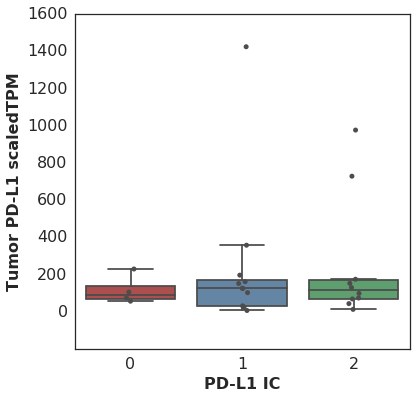

In [12]:
pdl1_data = cohort_expr_data[cohort_expr_data.gene_name == 'CD274']
def tumorPD_L1(row):
    vals = list(pdl1_data[
        pdl1_data.patient_id == row['patient_id']
    ]['scaledTPM'])
    return vals[0]
  
results = cohort.plot_correlation({"PD-L1 IC": lambda row: int(row["PD-L1"].split("IC")[1]),
                                    "Tumor PD-L1 scaledTPM": tumorPD_L1},
                                    plot_type="boxplot",
                                    x_col="PD-L1 IC",
                                    stat_func=spearmanr)
         
spearmanr_hyper_label_printer(results, label="tumor_pdl1_vs_ic_level")

In [13]:
# From Dissecting the multicellular ecosystem of metastatic melanoma by single-cell RNA-seq
EXHAUSTION_GENES_OF_INTEREST = [
    'PDCD1', # aka PD1, 
    'CD274', # aka PD-L1
    'TIGIT', 
    'LAG3', 
    'HAVCR2', # aka TIM3,
    'CTLA4'
]


CYTO_GENES_OF_INTEREST = [
    'NKG7',
    'CCL4',
    'CST7',
    'PRF1',
    'GZMA',
    'GZMB',
    'IFNG',
    'CCL3'
    
]

NAIVE_GENES_OF_INTEREST = [
    'CCR7',
    'TCF7',
    'LEF1',
    'SELL'
    
]

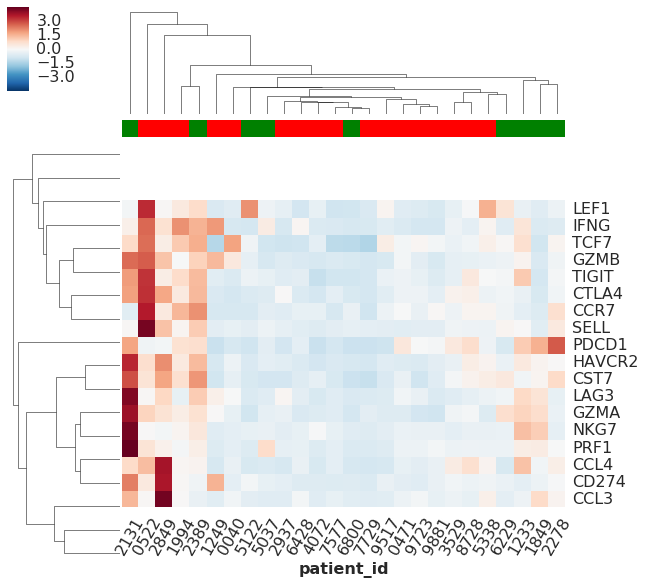

In [14]:
X = cohort_df.merge(kallisto_data).set_index('patient_id')
p = sb.clustermap(
    X[EXHAUSTION_GENES_OF_INTEREST + CYTO_GENES_OF_INTEREST + NAIVE_GENES_OF_INTEREST].T,
    z_score=0,
    # row_cluster=False,
    square=True,
    col_colors = ['green' if b else 'red' for b in X.benefit] 

)
r = plt.setp(p.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
r = plt.setp(p.ax_heatmap.xaxis.get_majorticklabels(), rotation=60)

{{{exhaustion_genes_of_interest}}}


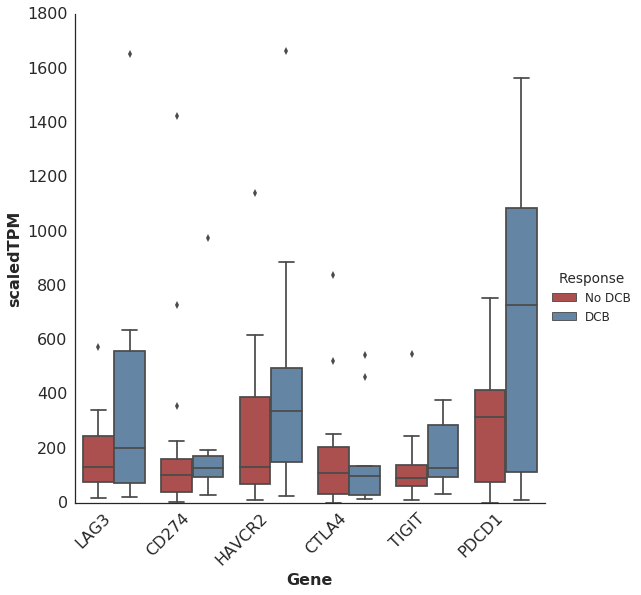

In [15]:
p = sb.factorplot(
    data = cohort_expr_data[cohort_expr_data.gene_name.isin(EXHAUSTION_GENES_OF_INTEREST)],
    hue = 'Response',
    y = 'scaledTPM',
    x = 'Gene',
    kind = 'box',
    size = 8
)
p.set_xticklabels(rotation=45, horizontalalignment='right')
print("{{{exhaustion_genes_of_interest}}}")

{{{exhaustion_genes_of_interest_swarm_pdl1}}}


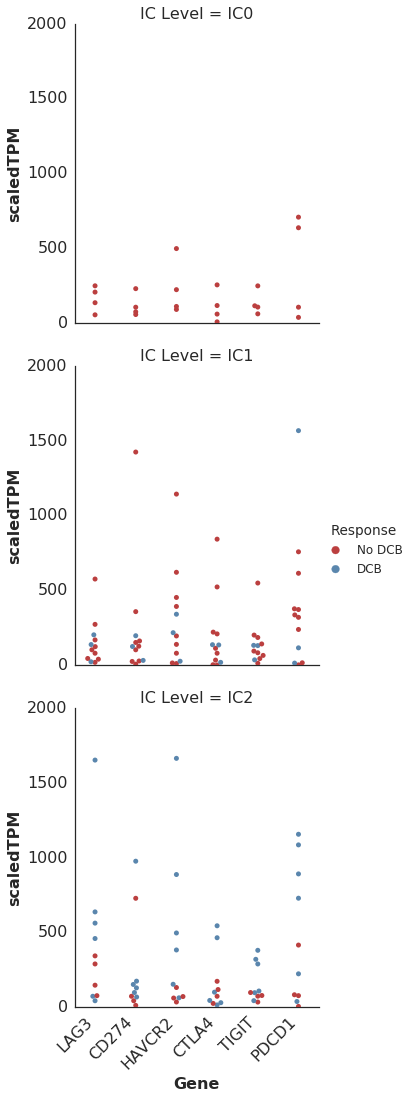

In [16]:
sb.set_context(font_scale=1.5)
p = sb.factorplot(
    data = cohort_expr_data[cohort_expr_data.gene_name.isin(EXHAUSTION_GENES_OF_INTEREST)],
    hue = 'Response',
    y = 'scaledTPM',
    x = 'Gene',
    kind = 'swarm',
    row = 'IC Level',
    size = 5
)
p.set_xticklabels(rotation=45, horizontalalignment='right')
# plt.setp(p.axes, sizes=[100])
p.set(ylim=(0, None))
print("{{{exhaustion_genes_of_interest_swarm_pdl1}}}")

{{{exhaustion_genes_of_interest_pdl1}}}


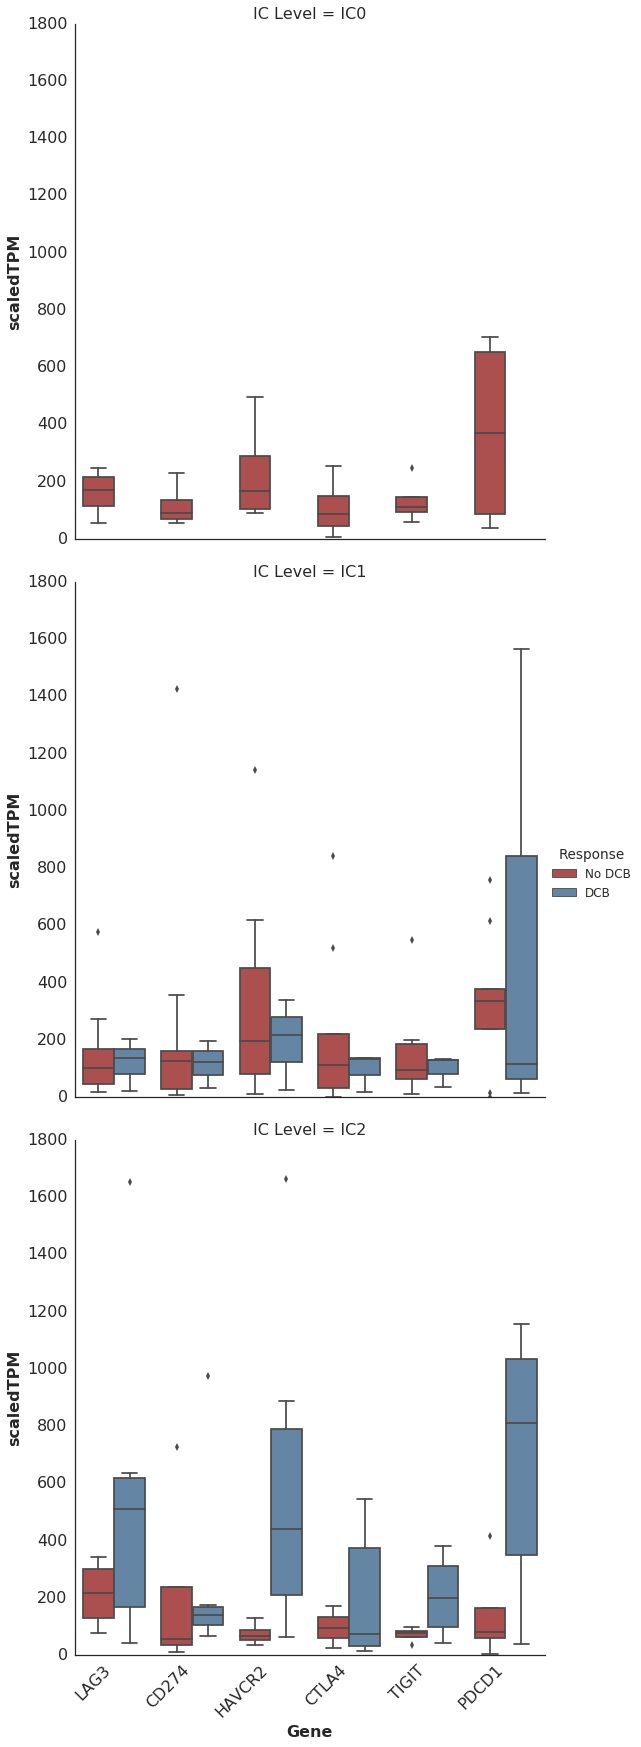

In [17]:
p = sb.factorplot(
    data = cohort_expr_data[cohort_expr_data.gene_name.isin(EXHAUSTION_GENES_OF_INTEREST)],
    hue = 'Response',
    y = 'scaledTPM',
    x = 'Gene',
    kind = 'box',
    row = 'IC Level',
    size = 8
)
p.set_xticklabels(rotation=45, horizontalalignment='right')
print("{{{exhaustion_genes_of_interest_pdl1}}}")